In [2]:
# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *
import pandas as pd
from datetime import datetime
import re
import nltk
import json
import numpy as np
from nltk import sent_tokenize, word_tokenize
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from string import punctuation
from textblob import TextBlob
#import contractions 
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report
import sklearn.tree
import re

%matplotlib inline
import csv
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split 
sns.set(style="darkgrid")

import gensim
from gensim.models import Phrases, KeyedVectors, Word2Vec
import gensim.downloader

from scipy import stats

# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('averaged_perceptron_tagger')
pass

## Problem Introduction

We have a dataset in JSON format containing information about the user activity in a reddit forum **ROAP**. Our feature set comes from a bunch of user features noted at the time of posting user comments in the forun alogside the titel and text they chose. The response variable is whether the requester received the pizza or not.

### 1. Loading the training data

In [3]:
with open('data/random-acts-of-pizza/train.json') as f:
    train_json_data = json.load(f)

In [6]:
df = pd.io.json.json_normalize(train_json_data) 
df.head()
pass

In [8]:
print('Total data rows in full training set: {}'.format(df.shape[0]))
print('Total data columns in full training set: {}'.format(df.shape[1]))

Total data rows in full training set: 4040
Total data columns in full training set: 32


### 2. Splitting training set into training and validation

As we don't have labeled test set, we have to split existing training data into training and validation set in order to evaluate our model performance. We have already split the train and validation in 90/10 ratio and saved as csv files. We read them directly in memory.

In [10]:
# split data in training and test data
train, val = train_test_split(df, test_size=0.1, random_state=42)

In [14]:
print(train.requester_received_pizza.value_counts())

print(val.requester_received_pizza.value_counts())

False    2746
True      890
Name: requester_received_pizza, dtype: int64
False    300
True     104
Name: requester_received_pizza, dtype: int64


### 3. Extracting relevant columns (present in test data) 

In [15]:
relevant_cols = ['request_title', 'request_text_edit_aware' ,
                 'requester_number_of_posts_on_raop_at_request', 
                'requester_number_of_subreddits_at_request', 
                 'unix_timestamp_of_request', 
                'requester_account_age_in_days_at_request',
                'requester_subreddits_at_request',
                'requester_upvotes_minus_downvotes_at_request', 
                'requester_upvotes_plus_downvotes_at_request']

y = 'requester_received_pizza'

In [16]:
def subset_df(data, y_cols, x_cols):
    return data[[y_cols] + x_cols]

In [17]:
train = subset_df(data=train, y_cols=y, x_cols=relevant_cols)
val = subset_df(data=val, y_cols=y, x_cols=relevant_cols)

### 4. Simple Text and Non-text features (function repo)

In [20]:
# Number of subreddits at request 
def num_subreddit_cuts(data, col, grid, lab):
    return pd.cut(data[col], grid, labels=lab)

In [33]:
def num_subreddit_dummy(data, colname):
    """
    data (pandas dataframe): input data frame
    colname (str): original column name
    """
    return pd.get_dummies(data=data, columns=[colname], drop_first=True)

In [36]:
def num_posts_roap(data, colname, id_colname,th=0):
    """
    data (pandas dataframe): input data frame
    colname (str): original column name
    id_colname (str): identifier for the created feature
    th (int): threshold for creating binary feature
    """
    new_colname = id_colname + '_' +colname
    feat = np.where(data[colname] == th, 0, 1)
    data[new_colname] = feat
    del data[colname]
    return data

In [37]:
def add_request_hour_feature(data, time_col, interval):
    """
    data (pandas dataframe): input data frame
    time_col (str): time indicator column
    interval (int): number of intervals 
    """
    data[time_col] =  pd.to_datetime(data[time_col],unit='s')
    hour_bin_int = pd.cut(data[time_col].dt.hour, interval)
    hour_col_name = time_col + '_' + str(interval)
    data[hour_col_name] = hour_bin_int
    data = data.drop(time_col, axis=1)
    return pd.get_dummies(data=data, columns=[hour_col_name], drop_first=True)

In [42]:
def simple_token_count(v):
    result = []
    for line in v:
        if line != line:
            result.append(1)
            continue
        result.append(len(word_tokenize(line)))
    return result

In [49]:
def lengths_feature(data):
    return [len(t) for t in data['request_text_edit_aware']]

def num_caps_feature(data):
    return [sum(1 for word in x.split() for c in word if c.isupper()) for x in data['request_text_edit_aware']]

def caps_vs_lengths_feature(data):
    return [sum(1 for word in x.split() for c in word if c.isupper())/
                       len(x) if len(x)>0 else 0 for x in data['request_text_edit_aware']]

def num_unique_words_feature(data):
    return [len(set(w for w in x.split())) for x in data['request_text_edit_aware']]

def num_punctuations_feature(data):
    puncs = '!"#$%&\'()*+,-./:;<=>?@[\\]^_{|}~`'
    return [sum(x.count(w) for w in puncs) for x in data['request_text_edit_aware']]

def requests_with_url(data):
    url_regex = re.compile(r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))")
    return [1 if len([f[0] for f in re.findall(url_regex,str(x))])>0 else 0 for x in data['request_text_edit_aware']]

In [60]:
def find_subreddit_freq_with_word(data, col, word):
    result = []
    for grp_list in data[col]:
        counter = 0
        for grp in grp_list:
            if word.lower() in grp.lower():
                counter += 1
        result.append(counter)
    return result

In [69]:
# stopwords from stopwords-json
stopwords_json = {"en":["a","a's","able","about","above","according","accordingly","across","actually","after","afterwards","again","against","ain't","all","allow","allows","almost","alone","along","already","also","although","always","am","among","amongst","an","and","another","any","anybody","anyhow","anyone","anything","anyway","anyways","anywhere","apart","appear","appreciate","appropriate","are","aren't","around","as","aside","ask","asking","associated","at","available","away","awfully","b","be","became","because","become","becomes","becoming","been","before","beforehand","behind","being","believe","below","beside","besides","best","better","between","beyond","both","brief","but","by","c","c'mon","c's","came","can","can't","cannot","cant","cause","causes","certain","certainly","changes","clearly","co","com","come","comes","concerning","consequently","consider","considering","contain","containing","contains","corresponding","could","couldn't","course","currently","d","definitely","described","despite","did","didn't","different","do","does","doesn't","doing","don't","done","down","downwards","during","e","each","edu","eg","eight","either","else","elsewhere","enough","entirely","especially","et","etc","even","ever","every","everybody","everyone","everything","everywhere","ex","exactly","example","except","f","far","few","fifth","first","five","followed","following","follows","for","former","formerly","forth","four","from","further","furthermore","g","get","gets","getting","given","gives","go","goes","going","gone","got","gotten","greetings","h","had","hadn't","happens","hardly","has","hasn't","have","haven't","having","he","he's","hello","help","hence","her","here","here's","hereafter","hereby","herein","hereupon","hers","herself","hi","him","himself","his","hither","hopefully","how","howbeit","however","i","i'd","i'll","i'm","i've","ie","if","ignored","immediate","in","inasmuch","inc","indeed","indicate","indicated","indicates","inner","insofar","instead","into","inward","is","isn't","it","it'd","it'll","it's","its","itself","j","just","k","keep","keeps","kept","know","known","knows","l","last","lately","later","latter","latterly","least","less","lest","let","let's","like","liked","likely","little","look","looking","looks","ltd","m","mainly","many","may","maybe","me","mean","meanwhile","merely","might","more","moreover","most","mostly","much","must","my","myself","n","name","namely","nd","near","nearly","necessary","need","needs","neither","never","nevertheless","new","next","nine","no","nobody","non","none","noone","nor","normally","not","nothing","novel","now","nowhere","o","obviously","of","off","often","oh","ok","okay","old","on","once","one","ones","only","onto","or","other","others","otherwise","ought","our","ours","ourselves","out","outside","over","overall","own","p","particular","particularly","per","perhaps","placed","please","plus","possible","presumably","probably","provides","q","que","quite","qv","r","rather","rd","re","really","reasonably","regarding","regardless","regards","relatively","respectively","right","s","said","same","saw","say","saying","says","second","secondly","see","seeing","seem","seemed","seeming","seems","seen","self","selves","sensible","sent","serious","seriously","seven","several","shall","she","should","shouldn't","since","six","so","some","somebody","somehow","someone","something","sometime","sometimes","somewhat","somewhere","soon","sorry","specified","specify","specifying","still","sub","such","sup","sure","t","t's","take","taken","tell","tends","th","than","thank","thanks","thanx","that","that's","thats","the","their","theirs","them","themselves","then","thence","there","there's","thereafter","thereby","therefore","therein","theres","thereupon","these","they","they'd","they'll","they're","they've","think","third","this","thorough","thoroughly","those","though","three","through","throughout","thru","thus","to","together","too","took","toward","towards","tried","tries","truly","try","trying","twice","two","u","un","under","unfortunately","unless","unlikely","until","unto","up","upon","us","use","used","useful","uses","using","usually","uucp","v","value","various","very","via","viz","vs","w","want","wants","was","wasn't","way","we","we'd","we'll","we're","we've","welcome","well","went","were","weren't","what","what's","whatever","when","whence","whenever","where","where's","whereafter","whereas","whereby","wherein","whereupon","wherever","whether","which","while","whither","who","who's","whoever","whole","whom","whose","why","will","willing","wish","with","within","without","won't","wonder","would","wouldn't","x","y","yes","yet","you","you'd","you'll","you're","you've","your","yours","yourself","yourselves","z","zero"]}
stopwords_json_en = set(stopwords_json['en'])
# adding some of our own stop words to NLTK's stopword list
stopwords_nltk_en = set(stopwords.words('english') + ['though','pizza', 'request', 'hey', 'hi'])
# create stop word list for punctuation
stopwords_punct = set(punctuation)
# combine the three stopwords lists
stoplist_combined = set.union(stopwords_json_en, stopwords_nltk_en, stopwords_punct)

In [68]:
wnl = WordNetLemmatizer()

def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n' 
    
def lemmatize_sent(text): 
    # Text input is string, returns lowercased strings.
    return [wnl.lemmatize(word.lower(), pos=penn2morphy(tag)) 
            for word, tag in pos_tag(word_tokenize(text))]

def preprocess_text_tfid(text):
    # Input: str, i.e. document/sentence
    # Output: str , i.e. list of lemmas
    # remove URLs
    text = re.sub(r'http\S+', '', text)
    # remove email addresses
    text = re.sub('\S+@\S+', '', text)
    # convert contractions to their full form
    #text = contractions.fix(text)
    # remove special characters after lemmatizing words
    processed_list = [re.sub('[^A-Za-z0-9]+', '', word) for word in lemmatize_sent(text)
              # remove words is they're on the stop words list or is a digit
            if word not in stoplist_combined
            and not word.isdigit()]
    # turn list of words into a string to that the output is the same format as the input
    return ' '.join(processed_list) 

def preprocess_text_pmi(text):
    # Input: str, i.e. document/sentence
    # Output: list(str) , i.e. list of lemmas
    # remove URLs
    text = re.sub(r'http\S+', '', text)
    # remove email addresses
    text = re.sub('\S+@\S+', '', text)
    return [word for word in lemmatize_sent(text) 
            if word not in stoplist_combined
            and not word.isdigit()]

In [112]:
def n_gram_nmf_features(data, data_val, col, n_topic, ngram):
    train_vectorizer = TfidfVectorizer(analyzer = 'word', 
                                   preprocessor = preprocess_text_tfid, 
                                   ngram_range = (ngram,ngram), min_df = 2, max_df = 0.95)

    train_vect = train_vectorizer.fit_transform(data[col])
    val_vect = train_vectorizer.transform(data_val[col])

    train_topic_model = NMF(n_components = n_topic, 
                            alpha = .1, 
                            l1_ratio = 0.5).fit(train_vect)

    train_topic_feat = train_topic_model.transform(train_vect)
    val_topic_feat = train_topic_model.transform(val_vect)
    
    new_colnames = ['nmf_' + str(ngram) + 'gram_f_'+str(i+1) for i in range(train_topic_feat.shape[1])]
    df_train = pd.DataFrame(train_topic_feat, columns=new_colnames)
    df_val = pd.DataFrame(val_topic_feat, columns=new_colnames)
    
    return df_train, df_val

In [132]:
def count_words_per_category(v, out):
    result_true, result_false, result_vocab = {}, {}, {}
    for ind, line in enumerate(v):
        #print(ind)
        #print(out[ind])
        trf_line = preprocess_text_pmi(line) # preprocess and lammatized title text
        for elem in trf_line:
            result_vocab[elem] = result_vocab.get(elem, 0) + 1
            
            if out[ind]:
                result_true[elem] = result_true.get(elem, 0) + 1
            else: 
                result_false[elem] = result_false.get(elem, 0) + 1
    
    return result_true, result_false, result_vocab

def pmi(inclass_freq, total_freq, class_freq, min_count=10):
    """
    inclass_freq (dict): dictionary containing inclass frequency for a given word
    total_freq (dict): dictionary containing total frequency for a given word
    class_freq (float): class prevalence
    min_count (int): minimum frequency for pmi calculation
    """
    pmi = {}
    for word, freq in total_freq.items():
        if freq < min_count:
            continue
        pmi[word] = np.log((inclass_freq.get(word, 0) + 0.001) * 1.0 / (class_freq * freq))
    return pmi

def get_counts(data, text_colname, outcome_colname):
    return count_words_per_category(data[text_colname], 
                                    list(data[outcome_colname]))

def get_top_k_from_dict(d, k):
    return sorted(d.items(), key=lambda kv: kv[1])[-k:]

def get_words(sorted_dict):
    return [w[0] for w in sorted_dict]

def calculate_pmi(data, text_colname, outcome_colname, class_freq_true, top_k):
    count_class_true, count_class_false, count_total = get_counts(data = data, 
                                                         text_colname=text_colname, 
                                                         outcome_colname=outcome_colname) 
    pmi_true = pmi(inclass_freq=count_class_true, 
                   total_freq=count_total, 
                   class_freq=class_freq_true)
    
    pmi_false = pmi(inclass_freq=count_class_false, 
                   total_freq=count_total, 
                   class_freq=1-class_freq_true)
    
    pmi_true_top_k = get_top_k_from_dict(pmi_true, k=top_k)
    pmi_false_top_k = get_top_k_from_dict(pmi_false, k=top_k)
    
    pmi_true_words = get_words(pmi_true_top_k)
    pmi_false_words = get_words(pmi_false_top_k)
    
    return pmi_true_words, pmi_false_words

In [135]:
def get_binary_feature(word, vector, wv):
    result = []
    candidates = set([w[0] for w in wv.most_similar(word, topn=20)] + [word])
    for line in vector:
        if line != line:
            result.append(0)
            continue
        trf_line = preprocess_text_pmi(line)
        if len(candidates.intersection(set(trf_line))) > 0:
            result.append(1)
        else:
            result.append(0)
    return result

def text_feature_addition(word_list, df, colname, id_str, wv):
    for ind, word in enumerate(word_list):
        print(ind, ' : ', word)
        f_name = id_str + word
        feat = get_binary_feature(word, df[colname], wv)
        df[f_name] = feat
    return df

### 5. Feature addition

In [34]:
t1 = num_subreddit_cuts(data = train, 
                        col = 'requester_number_of_subreddits_at_request', 
                        grid = [-np.inf, 0, 5, 10, 50, 100, np.inf], 
                        lab = ['0. 0','1. 1-5', '2. 5-10', '3. 10-50', '4. 50-100', '5. 100+'])

v1 = num_subreddit_cuts(data = val, 
                        col = 'requester_number_of_subreddits_at_request', 
                        grid = [-np.inf, 0, 5, 10, 50, 100, np.inf], 
                        lab = ['0. 0','1. 1-5', '2. 5-10', '3. 10-50', '4. 50-100', '5. 100+'])

train.loc[:,'num_subreddits_req'] = t1
val.loc[:,'num_subreddits_req'] = v1

train = num_subreddit_dummy(data = train, colname= 'num_subreddits_req')
val = num_subreddit_dummy(data = val, colname= 'num_subreddits_req')

In [38]:
train = num_posts_roap(data=train, colname='requester_number_of_posts_on_raop_at_request', id_colname='binary')
val = num_posts_roap(data=val, colname='requester_number_of_posts_on_raop_at_request', id_colname='binary')

In [40]:
train = add_request_hour_feature(data = train, time_col='unix_timestamp_of_request', interval=4)
val = add_request_hour_feature(data = val, time_col='unix_timestamp_of_request', interval=4)

In [43]:
train.loc[:,'title_length'] = simple_token_count(train.request_title)
train.loc[:,'text_length'] = simple_token_count(train.request_text_edit_aware)
val.loc[:,'title_length'] = simple_token_count(val.request_title)
val.loc[:,'text_length'] = simple_token_count(val.request_text_edit_aware)

In [61]:
train.loc[:,'active_random_subr'] = find_subreddit_freq_with_word(data=train, col='requester_subreddits_at_request', word='random')
train.loc[:,'active_raop_subr'] = find_subreddit_freq_with_word(data=train, col='requester_subreddits_at_request', word='Random_Acts_Of_Pizza')
train.loc[:,'active_food_subr'] = find_subreddit_freq_with_word(data=train, col='requester_subreddits_at_request', word='food')

val.loc[:,'active_random_subr'] = find_subreddit_freq_with_word(data=val, col='requester_subreddits_at_request', word='random')
val.loc[:,'active_raop_subr'] = find_subreddit_freq_with_word(data=val, col='requester_subreddits_at_request', word='Random_Acts_Of_Pizza')
val.loc[:,'active_food_subr'] = find_subreddit_freq_with_word(data=val, col='requester_subreddits_at_request', word='food')

In [65]:
train.loc[:,'lengths_text'] = lengths_feature(data=train)
train.loc[:,'num_caps_text'] = num_caps_feature(data=train)
train.loc[:,'capsvslen_text'] = caps_vs_lengths_feature(data=train)
train.loc[:,'num_unique_words_text'] = num_unique_words_feature(data=train)
train.loc[:,'num_puncs_text'] = num_punctuations_feature(data=train)
train.loc[:,'num_req_w_url_text'] = requests_with_url(data=train)

val.loc[:,'lengths_text'] = lengths_feature(data=val)
val.loc[:,'num_caps_text'] = num_caps_feature(data=val)
val.loc[:,'capsvslen_text'] = caps_vs_lengths_feature(data=val)
val.loc[:,'num_unique_words_text'] = num_unique_words_feature(data=val)
val.loc[:,'num_puncs_text'] = num_punctuations_feature(data=val)
val.loc[:,'num_req_w_url_text'] = requests_with_url(data=val)

In [113]:
bigram_nmf_train, bigram_nmf_val = n_gram_nmf_features(data=train, data_val=val, 
                                                       col='request_text_edit_aware', n_topic=5, ngram=2)

unigram_nmf_train, unigram_nmf_val = n_gram_nmf_features(data=train, data_val=val, 
                                                       col='request_text_edit_aware', n_topic=10, ngram=1)

In [125]:
train.reset_index(inplace=True, drop=True)
val.reset_index(inplace=True, drop=True)
train = pd.concat([train, bigram_nmf_train, unigram_nmf_train], axis=1)
val = pd.concat([val, bigram_nmf_val, unigram_nmf_val], axis=1)

In [127]:
w_vect = gensim.downloader.load('glove-twitter-50')

In [134]:
true_class_pmi_words_title, false_class_pmi_words_title = calculate_pmi(data = train, 
                                                                        text_colname='request_title', 
                                                                        outcome_colname='requester_received_pizza', 
                                                                        class_freq_true=0.24505, 
                                                                        top_k=10)

true_class_pmi_words_text, false_class_pmi_words_text = calculate_pmi(data = train, 
                                                                      text_colname='request_text_edit_aware', 
                                                                      outcome_colname='requester_received_pizza', 
                                                                      class_freq_true=0.24505, 
                                                                      top_k=10)

In [136]:
train = text_feature_addition(word_list=false_class_pmi_words_text, 
                                    df=train, 
                                    colname='request_text_edit_aware', 
                                    wv=w_vect, 
                                    id_str='text_false_')

train = text_feature_addition(word_list=true_class_pmi_words_text, 
                                    df=train, 
                                    colname='request_text_edit_aware', 
                                    wv=w_vect, 
                                    id_str='text_true_')

train = text_feature_addition(word_list=false_class_pmi_words_title, 
                                    df=train, 
                                    colname='request_title', 
                                    wv=w_vect, 
                                    id_str='title_false_')

train = text_feature_addition(word_list=true_class_pmi_words_title, 
                                    df=train, 
                                    colname='request_title', 
                                    wv=w_vect, 
                                    id_str='title_true_')

0  :  english
1  :  ta
2  :  animal
3  :  ga
4  :  dead
5  :  essay
6  :  bc
7  :  tide
8  :  needless
9  :  fancy
0  :  individual
1  :  puppy
2  :  fry
3  :  sum
4  :  admit
5  :  kidney
6  :  lawyer
7  :  collect
8  :  package
9  :  bonus
0  :  people
1  :  ct
2  :  jersey
3  :  order
4  :  noodle
5  :  enjoy
6  :  na
7  :  pepperoni
8  :  wan
9  :  class
0  :  fail
1  :  smile
2  :  anniversary
3  :  nj
4  :  father
5  :  baby
6  :  daughter
7  :  tucson
8  :  happy
9  :  lot


In [137]:
val = text_feature_addition(word_list=false_class_pmi_words_text, 
                                    df=val, 
                                    colname='request_text_edit_aware', 
                                    wv=w_vect, 
                                    id_str='text_false_')

val = text_feature_addition(word_list=true_class_pmi_words_text, 
                                    df=val, 
                                    colname='request_text_edit_aware', 
                                    wv=w_vect, 
                                    id_str='text_true_')

val = text_feature_addition(word_list=false_class_pmi_words_title, 
                                    df=val, 
                                    colname='request_title', 
                                    wv=w_vect, 
                                    id_str='title_false_')

val = text_feature_addition(word_list=true_class_pmi_words_title, 
                                    df=val, 
                                    colname='request_title', 
                                    wv=w_vect, 
                                    id_str='title_true_')

0  :  english
1  :  ta
2  :  animal
3  :  ga
4  :  dead
5  :  essay
6  :  bc
7  :  tide
8  :  needless
9  :  fancy
0  :  individual
1  :  puppy
2  :  fry
3  :  sum
4  :  admit
5  :  kidney
6  :  lawyer
7  :  collect
8  :  package
9  :  bonus
0  :  people
1  :  ct
2  :  jersey
3  :  order
4  :  noodle
5  :  enjoy
6  :  na
7  :  pepperoni
8  :  wan
9  :  class
0  :  fail
1  :  smile
2  :  anniversary
3  :  nj
4  :  father
5  :  baby
6  :  daughter
7  :  tucson
8  :  happy
9  :  lot


In [145]:
train.iloc[:, :10].dtypes

requester_received_pizza                           bool
request_title                                    object
request_text_edit_aware                          object
requester_number_of_subreddits_at_request         int64
requester_account_age_in_days_at_request        float64
requester_subreddits_at_request                  object
requester_upvotes_minus_downvotes_at_request      int64
requester_upvotes_plus_downvotes_at_request       int64
num_subreddits_req_1. 1-5                         uint8
num_subreddits_req_2. 5-10                        uint8
dtype: object

In [146]:
exclude_cols = ['requester_received_pizza', 'request_title', 'request_text_edit_aware', 'requester_subreddits_at_request']
Xcols=[c for c in train.columns if c not in exclude_cols]

### 6. Parameter tuning

In [152]:
# Number of trees in Random Forest
rf_n_estimators = [int(x) for x in np.linspace(200, 1000, 5)]

# Maximum number of levels in tree
rf_max_depth = [int(x) for x in np.linspace(1, 10, 1)]
# Add the default as a possible value
rf_max_depth.append(None)

# Number of features to consider at every split
rf_max_features = ['auto', 'log2', 8, 10, 15, 20, 50, 70]

# Minimum number of samples required to split a node
rf_min_samples_split = [int(x) for x in np.linspace(4, 10, 7)]

# Method of selecting samples for training each tree
rf_bootstrap = [True, False]

rf_class_weight = [None, 'balanced', 'balanced_subsample']

# Create the grid
rf_grid = {'n_estimators': rf_n_estimators,
            'max_depth': rf_max_depth,
            'max_features': rf_max_features,
            'min_samples_split': rf_min_samples_split,
            'bootstrap': rf_bootstrap, 
            'class_weight': rf_class_weight}

rf_base = RandomForestClassifier()

# Create the random search Random Forest
rf_random = RandomizedSearchCV(estimator = rf_base, param_distributions = rf_grid, 
                               n_iter = 400, cv = 3, verbose = 1, random_state = 42, 
                               n_jobs = -1)

# Fit the random search model
rf_random.fit(train[Xcols], train[y])

# View the best parameters from the random search
rf_random.best_params_

Fitting 3 folds for each of 400 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   53.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 12.7min
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed: 20.3min finished


{'n_estimators': 800,
 'min_samples_split': 5,
 'max_features': 20,
 'max_depth': None,
 'class_weight': None,
 'bootstrap': True}

In [153]:
rf_final = RandomForestClassifier(n_estimators=800, min_samples_split=5, max_features=20, 
                                  max_depth=None, class_weight=None,
                                 bootstrap=True, n_jobs=-1, random_state=42)

rf_final.fit(train[Xcols], train[y])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=20, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=800,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

### 7. Prediction

In [154]:
prediction_probs = rf_final.predict_proba(val[Xcols])[:,1]

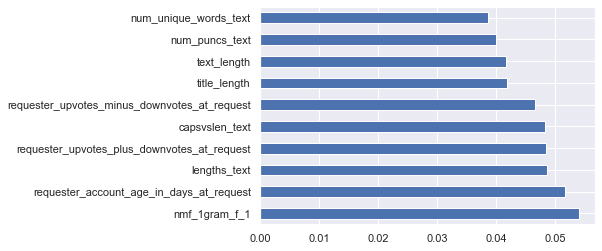

In [155]:
feat_importances = pd.Series(rf_final.feature_importances_, index=Xcols)
feat_importances.nlargest(10).plot(kind='barh')
pass

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


Best Threshold=0.162872, F-Score=0.466


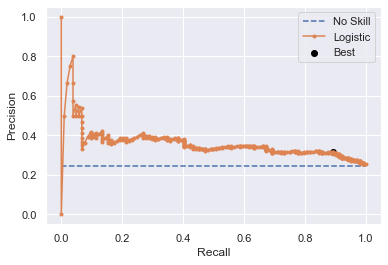

In [156]:
# calculate roc curves
precision, recall, thresholds = precision_recall_curve(val[y], prediction_probs)
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.nanargmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
# plot the roc curve for the model
no_skill = 0.24505
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='Logistic')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
# show the plot
plt.show()

In [157]:
pred_label = prediction_probs>=0.162872

In [158]:
print(classification_report(y_true=val[y], y_pred=pred_label))

              precision    recall  f1-score   support

       False       0.90      0.33      0.48       300
        True       0.32      0.89      0.47       104

    accuracy                           0.47       404
   macro avg       0.61      0.61      0.47       404
weighted avg       0.75      0.47      0.48       404

